In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *
from alvra_tools.XAS_functions import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')

# Load data

In [3]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_XANES'

runlist = np.arange(24, 26)
#runlist = [25]
##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scans of {} steps each'.format(len(runlist), np.shape(Pump_probe_Diode1)[1]))

[24 25]
2 scans of 91 steps each


# ONE diode: 
* [Plot averaged curves](#Ave_data)
* [Overlay different scans](#Overlay)

# TWO diodes:
* [Plot averaged curves](#Ave_data_2)
* [Overlay different scans](#Overlay2)


<a id='Ave_data'></a>
## Average scans 1 diode

In [3]:
#### CH1 ####
DataDiode1_pump   = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1        = np.asarray(goodshots1)

XAS1_pump        = np.mean(DataDiode1_pump[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump[:,:,0]-DataDiode1_pump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump[:,:,2]-DataDiode1_pump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump[:,:,0]-DataDiode1_unpump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump[:,:,2]-DataDiode1_unpump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe_Diode1[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

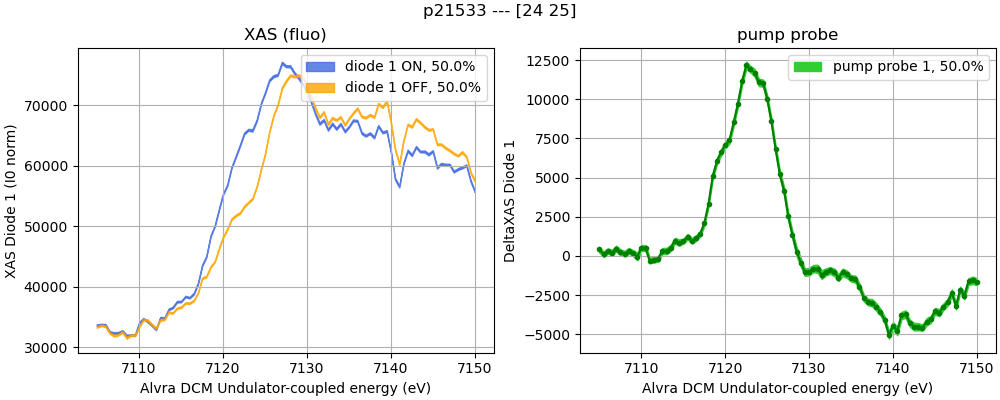

In [4]:
quantile_corr = 0.5
Energy_eV = np.asarray(Energy_eV[0])

#fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle(titlestring_stack)

ax1.fill_between(Energy_eV, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Energy_eV, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Energy_eV, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Energy_eV, XAS1_pump_probe, color='green', marker='.')

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("{} ({})".format(label, units))
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()


plt.show()

## save the averaged spectra 

In [135]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe_Diode1[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1, axis=0)

#save_run_array_XANES(reducedir, run_name, Energy_eV, DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg)
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0024-Febpy_XAS_PIPS_APD_1ps


<a id='Overlay'></a>
## Overlay different scans 1 diode

In [136]:
pgroup = 'p21533'
runlist = np.arange(24, 26, 1)
#runlist = [164, 166]
Loaddir_folder = 'Reduced_XANES'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [24 25] from /sf/alvra/data/p21533/work/Claudio/Reduced_XANES/


['/sf/alvra/data/p21533/work/Claudio/Reduced_XANES/run0024-Febpy_XAS_PIPS_APD_1ps/run_array.npy',
 '/sf/alvra/data/p21533/work/Claudio/Reduced_XANES/run0025-Febpy_XAS_PIPS_APD_1ps/run_array.npy']

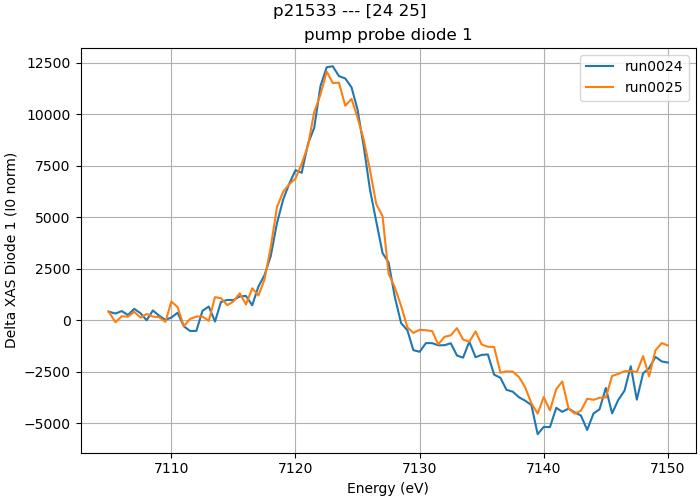

In [125]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

keys = []
#lab = ['DMM','N2Q','N4PY']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber)
        #ax1.axes.errorbar(Delay_fs, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe)
        
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
#ax1.set_xlim(-1000, 50000)
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')
plt.show()

In [126]:
len(Energy_eV)

91

<a id='Ave_data_2'></a>
## Average scans 2 diodes

In [137]:
#### CH1 ####
DataDiode1_pump   = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1        = np.asarray(goodshots1)

XAS1_pump        = np.mean(DataDiode1_pump[:,:,0], axis=0)
err1_low_pump    = np.mean((DataDiode1_pump[:,:,0]-DataDiode1_pump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_pump   = np.mean((DataDiode1_pump[:,:,2]-DataDiode1_pump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_unpump      = np.mean(DataDiode1_unpump[:,:,0], axis=0)
err1_low_unpump  = np.mean((DataDiode1_unpump[:,:,0]-DataDiode1_unpump[:,:,1])/np.sqrt(goodshots1), axis=0)
err1_high_unpump = np.mean((DataDiode1_unpump[:,:,2]-DataDiode1_unpump[:,:,0])/np.sqrt(goodshots1), axis=0)

XAS1_pump_probe       = np.mean(Pump_probe_Diode1[:,:,0], axis=0)
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
DataDiode2_pump   = np.asarray(DataDiode2_pump)
DataDiode2_unpump = np.asarray(DataDiode2_unpump)
Pump_probe_Diode2 = np.asarray(Pump_probe_Diode2)
goodshots2        = np.asarray(goodshots2)

XAS2_pump        = np.mean(DataDiode2_pump[:,:,0], axis=0)
err2_low_pump    = np.mean((DataDiode2_pump[:,:,0]-DataDiode2_pump[:,:,1])/np.sqrt(goodshots2), axis=0)
err2_high_pump   = np.mean((DataDiode2_pump[:,:,2]-DataDiode2_pump[:,:,0])/np.sqrt(goodshots2), axis=0)

XAS2_unpump      = np.mean(DataDiode2_unpump[:,:,0], axis=0)
err2_low_unpump  = np.mean((DataDiode2_unpump[:,:,0]-DataDiode2_unpump[:,:,1])/np.sqrt(goodshots2), axis=0)
err2_high_unpump = np.mean((DataDiode2_unpump[:,:,2]-DataDiode2_unpump[:,:,0])/np.sqrt(goodshots2), axis=0)

XAS2_pump_probe       = np.mean(Pump_probe_Diode2[:,:,0], axis=0)
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)


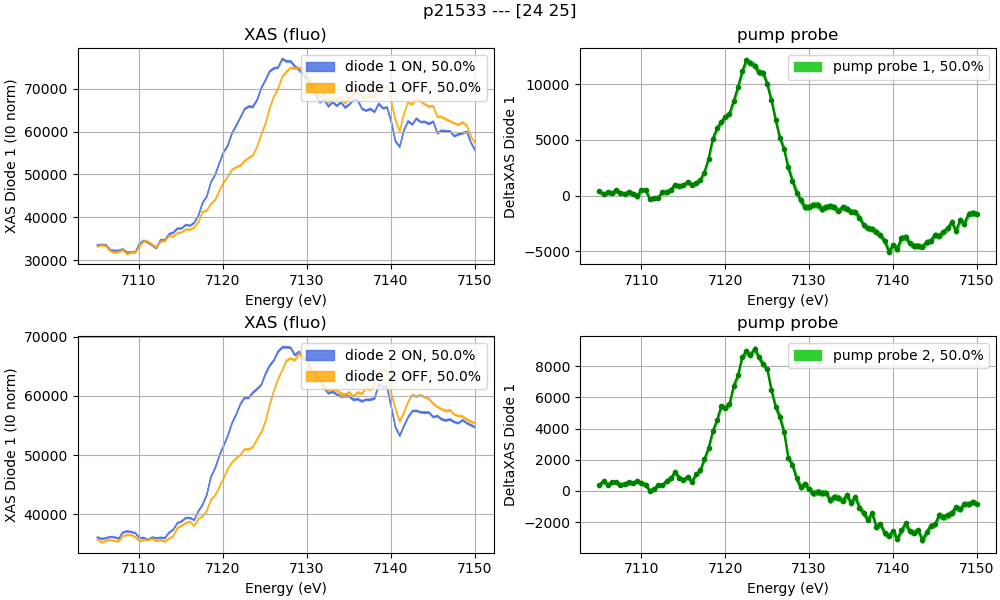

In [138]:
quantile_corr = 0.5
Energy_eV = np.asarray(Energy_eV[0])

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
plt.suptitle(titlestring_stack)

ff = glob.glob(Loaddir+'/*{:04d}*/XANES_energy_eV.npy'.format(runlist[0]))
Energy_eV = np.load(ff[0])

ax1.fill_between(Energy_eV, XAS1_pump - err1_low_pump, XAS1_pump + err1_high_pump , label='diode 1 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax1.fill_between(Energy_eV, XAS1_unpump - err1_low_unpump, XAS1_unpump + err1_high_unpump, label='diode 1 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax3.fill_between(Energy_eV, XAS1_pump_probe - err1_low_pump_probe, XAS1_pump_probe + err1_low_pump_probe, label='pump probe 1, {}%'.format(quantile_corr*100),color='limegreen')
ax3.plot(Energy_eV, XAS1_pump_probe, color='green', marker='.')
#ax3.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))

ax2.fill_between(Energy_eV, XAS2_pump - err2_low_pump, XAS2_pump + err2_high_pump , label='diode 2 ON, {}%'.format(quantile_corr*100), color='royalblue', alpha = 0.8)
ax2.fill_between(Energy_eV, XAS2_unpump - err2_low_unpump, XAS2_unpump + err2_high_unpump, label='diode 2 OFF, {}%'.format(quantile_corr*100),color='orange', alpha = 0.8)
ax4.fill_between(Energy_eV, XAS2_pump_probe - err2_low_pump_probe, XAS2_pump_probe + err2_low_pump_probe, label='pump probe 2, {}%'.format(quantile_corr*100),color='limegreen')
ax4.plot(Energy_eV, XAS2_pump_probe, color='green', marker='.')
#ax4.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))

ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("XAS Diode 1 (I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel ("DeltaXAS Diode 1")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("XAS Diode 1 (I0 norm)")
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax4.set_xlabel("Energy (eV)")
ax4.set_ylabel ("DeltaXAS Diode 1")
ax4.set_title('pump probe')
ax4.legend(loc="best")
ax4.grid()

plt.show()

## save the averaged spectra

In [59]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_timescans/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe_Diode1[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1, axis=0)
DataDiode2_pump_avg   = np.mean(DataDiode2_pump[:,:,:], axis=0)
DataDiode2_unpump_avg = np.mean(DataDiode2_unpump[:,:,:], axis=0)
Pump_probe2_avg       = np.mean(Pump_probe_Diode2[:,:,:], axis=0)
goodshots2_avg        = np.mean(goodshots2, axis=0)

# save_run_array_XANES_2diodes(reducedir, run_name, Energy_eV, 
#                              DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg,
#                              DataDiode2_pump_avg, DataDiode2_unpump_avg, Pump_probe2_avg, goodshots2_avg)
print (reducedir+run_name)

../Claudio/Reduced_timescans/averaged/run0024-Febpy_XAS_PIPS_APD_1ps


<a id='Overlay2'></a>
## Overlay different scans 2 diodes

In [60]:
pgroup = 'p21533'
runlist = np.arange(24, 26, 1)
#runlist = [164, 166]
Loaddir_folder = 'Reduced_XANES'

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_folder)
titlestring_stack = pgroup + ' --- ' +str(runlist)
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [24 25] from /sf/alvra/data/p21533/work/Claudio/Reduced_XANES/


['/sf/alvra/data/p21533/work/Claudio/Reduced_XANES/run0024-Febpy_XAS_PIPS_APD_1ps/run_array.npy',
 '/sf/alvra/data/p21533/work/Claudio/Reduced_XANES/run0025-Febpy_XAS_PIPS_APD_1ps/run_array.npy']

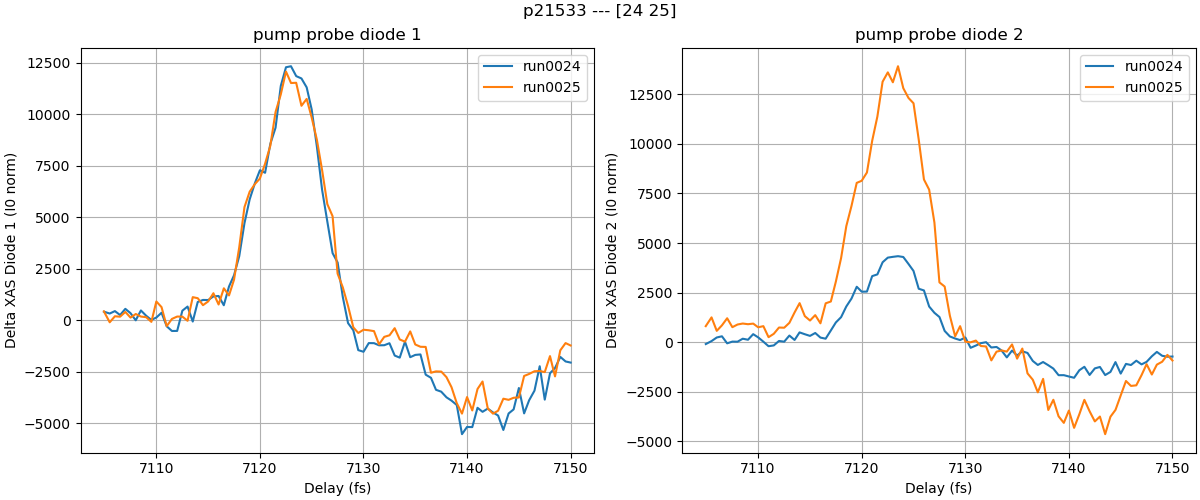

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)
if 'averaged' in Loaddir:
    plt.suptitle(titlestring_stack + ' averaged')

keys = []

for run in runlist:
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        if 'averaged' in Loaddir:
            runnumber = run_array[key]["name"].split('-')[0] + '_avg'
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber)
    
        
        XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
        D2p = run_array[key]["DataDiode2_pump"]
        D2u = run_array[key]["DataDiode2_unpump"]
        gs2 = run_array[key]["goodshots2"]

        err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
        err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
        err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
        err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)

        err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
        err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

        ax2.plot(Energy_eV, XAS2_pump_probe[:,0], label=runnumber)        
        
ax1.set_xlabel("Delay (fs)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()
ax2.set_xlabel("Delay (fs)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 1')
ax2.set_title('pump probe diode 2')

plt.show()

## Average the 2 diodes

In [64]:
##Average first, subtract later

ave_unpump = (XAS1_unpump-np.mean(XAS1_unpump[0:5]) + XAS2_unpump-np.mean(XAS2_unpump[0:5]))/2        ### subtracts the baseline
ave_unpump_err_l = np.sqrt(err1_low_unpump**2+err2_low_unpump**2)
ave_unpump_err_h = np.sqrt(err1_high_unpump**2+err1_high_unpump**2)

ave_pump = (XAS1_pump-np.mean(XAS1_pump[0:5]) + XAS2_pump-np.mean(XAS2_pump[0:5]))/2                  ### subtracts the baseline
ave_pump_err_l = np.sqrt(err1_low_pump**2+err2_low_pump**2)
ave_pump_err_h = np.sqrt(err1_high_pump**2+err1_high_pump**2)

ave_pp1 = ave_pump - ave_unpump
ave_pp_err_l1 = np.sqrt(ave_unpump_err_l**2+ave_pump_err_l**2)
ave_pp_err_h1 = np.sqrt(ave_unpump_err_h**2+ave_pump_err_h**2)

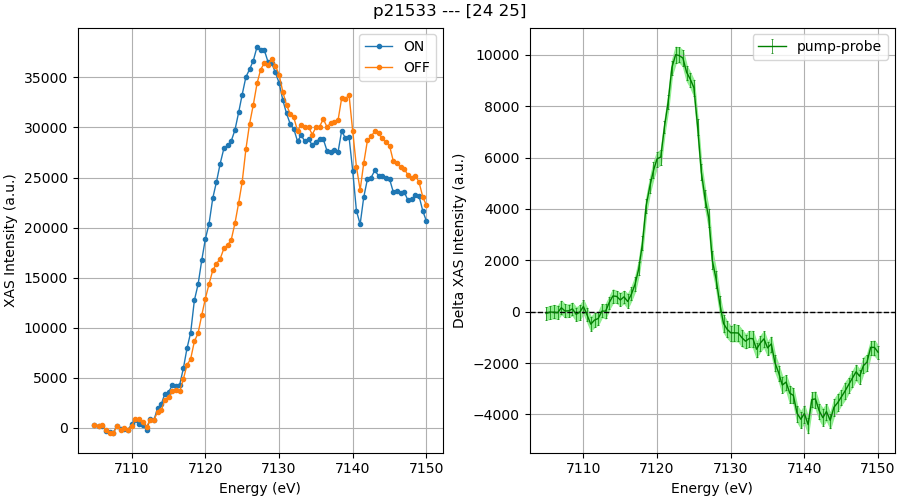

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

ax1.plot(Energy_eV,ave_pump,lw=1,marker='o',markersize=3,label='ON')
ax1.plot(Energy_eV,ave_unpump,lw=1,marker='o',markersize=3,label='OFF')
ax1.grid()
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.legend()

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Energy_eV, ave_pp1, (ave_pp_err_l1, ave_pp_err_h1), 
              lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                   ecolor='green',elinewidth=0.5,label='pump-probe')
ax2.fill_between(Energy_eV,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.grid()
ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel('Energy (eV)')
ax2.set_ylabel('Delta XAS Intensity (a.u.)')
ax2.legend()
plt.show()

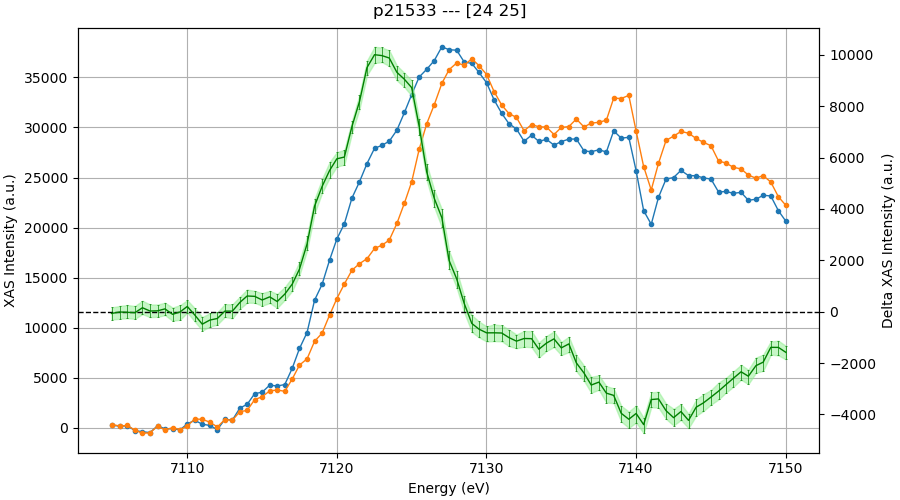

In [69]:
fig, ax1= plt.subplots(1, 1, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring_stack)

ax1.plot(Energy_eV,ave_pump,lw=1,marker='o',markersize=3,label='ON') 
ax1.plot(Energy_eV,ave_unpump,lw=1,marker='o',markersize=3,label='ON') 
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.grid()
ax1.set_xlabel('Energy (eV)')

ax2 = plt.twinx(ax1)
ax2.axes.errorbar(Energy_eV, ave_pp1, (ave_pp_err_l1, ave_pp_err_h1), 
              lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                   ecolor='green',elinewidth=0.5,label='pump-probe')
ax2.fill_between(Energy_eV,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen', alpha=0.5)
ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_ylabel('Delta XAS Intensity (a.u.)')
plt.show()

## save the averaged spectra to load them overlaid

In [ ]:
run_name = glob.glob(Loaddir + '/*{:04d}*'.format(runlist[0]))[0].split('/')[-1]
reducedir ='../Claudio/Reduced_XANES/averaged/'
os.makedirs(reducedir+run_name, exist_ok=True)

DataDiode1_pump_avg   = np.mean(DataDiode1_pump_all[:,:,:], axis=0)
DataDiode1_unpump_avg = np.mean(DataDiode1_unpump_all[:,:,:], axis=0)
Pump_probe1_avg       = np.mean(Pump_probe1_all[:,:,:], axis=0)
goodshots1_avg        = np.mean(goodshots1_all, axis=0)

save_run_array_XANES(reducedir, run_name, Energy_eV, DataDiode1_pump_avg, DataDiode1_unpump_avg, Pump_probe1_avg, goodshots1_avg)
print (reducedir+run_name)

# Overlay different XANES  spectra
### load data

In [15]:
#runlist = np.arange(246, 249, 1)
#runlist = [27,25,28,23,24]
runlist = [42, 97]

Loaddir = '../Claudio/Reduced_XANES/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*npy*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 2 runs: [42, 97] from ../Claudio/Reduced_XANES/


['../Claudio/Reduced_XANES/run0042-FeOX_RIXS_pre-edge_150fs_16uJ/run_array.npy',
 '../Claudio/Reduced_XANES/run0097-FeOX_RIXS_pre-edge_150fs_16uJ_055/run_array.npy']

# TWO DIODES

No handles with labels found to put in legend.


Diode2 files not found
Diode2 files not found


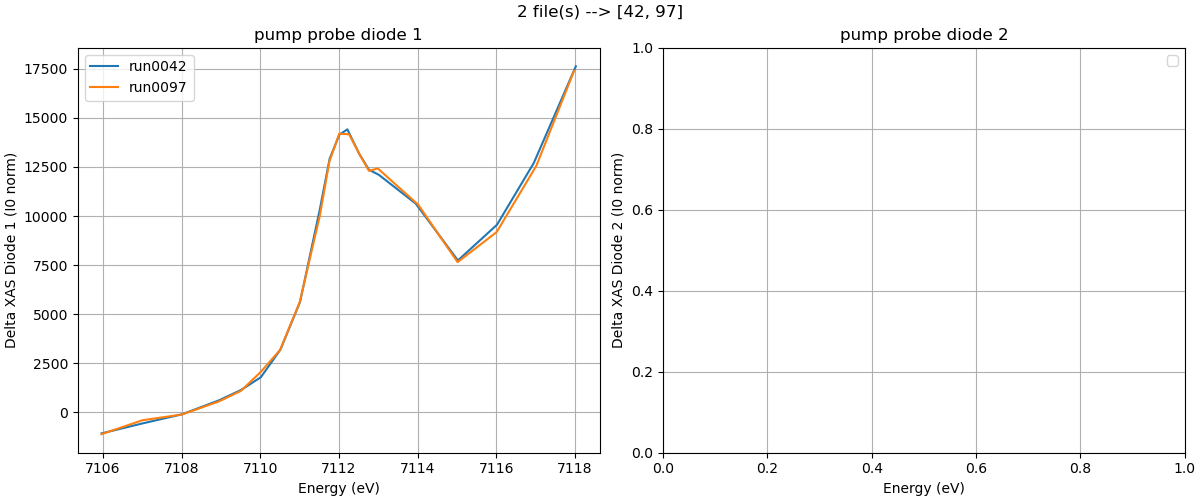

[42, 97]


In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

delays = ['150fs','2ps','10ps','50ps', '75fs']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        lab = delays[index]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        #ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber+': '+lab)
        ax1.plot(Energy_eV, (D1u[:,0] - np.mean(D1u[:5,0])) , label=runnumber)
        #ax2.plot(Energy_eV, (D1u[:,0] - np.mean(D1u[:5,0]))/np.max(D1u[:,0]) , label=runnumber)
        #ax1.plot(Energy_eV, D1p[:,0])
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_unpump, err1_high_unpump, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        
        try:
            XAS2_pump_probe = run_array[key]["Pump_probe_Diode2"]
            D2p = run_array[key]["DataDiode2_pump"]
            D2u = run_array[key]["DataDiode2_unpump"]
            gs2 = run_array[key]["goodshots2"]
            
            err2_low_pump    = (D2p[:,0]-D2p[:,1])/np.sqrt(gs2)
            err2_high_pump   = (D2p[:,2]-D2p[:,0])/np.sqrt(gs2)
            err2_low_unpump  = (D2u[:,0]-D2u[:,1])/np.sqrt(gs2)
            err2_high_unpump = (D2u[:,2]-D2u[:,0])/np.sqrt(gs2)
        
            err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
            err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)
            
            #ax2.plot(Energy_eV, XAS2_pump_probe[:,0])
            #ax2.axes.errorbar(Energy_eV, D2u[:,0], err2_low_unpump, err2_high_unpump, label=runnumber)
        
        except:
            print ('Diode2 files not found')
        
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.grid()
ax1.legend()

ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel ("Delta XAS Diode 2 (I0 norm)")
ax2.legend()
ax2.grid()

ax1.set_title('pump probe diode 1')
ax2.set_title('pump probe diode 2')

plt.show()
print(runlist)

# ONE diode

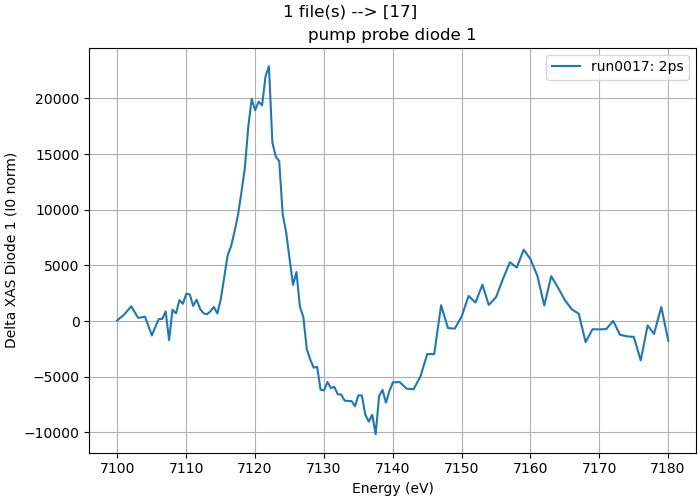

In [11]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []
#runlist = [71, 73, 74] #excluding run 65 test
delays = ['2ps','2ps','10ps','50ps', '75fs']

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        lab = delays[index]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.plot(Energy_eV, XAS1_pump_probe[:,0], label=runnumber+': '+lab)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], (err1_low_pump_probe + err1_high_pump_probe)/2, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/max(XAS1_pump_probe[:,0]), err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, D1u[:,0]-np.mean(D1u[:5,0]), (err1_low_pump_probe+err1_high_pump_probe)/2, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2466.35,2466.75, 2469.55, 2472], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')
plt.show()

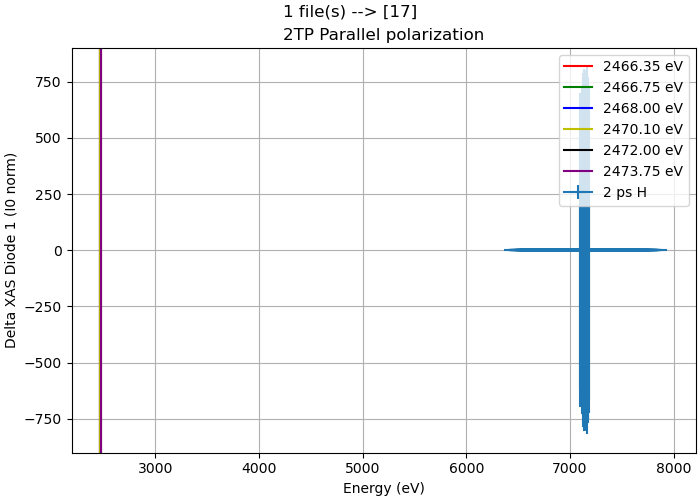

In [8]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

labels = ['200 fs H', '200 fs V', '500 fs H', '500 fs V','2 ps H', '2 ps V']
labels = ['2 ps H', '2 ns H', ]

for i, (run, lbl) in enumerate(zip(runlist[::],labels[::])):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/norm, err1_low_pump_probe, err1_high_pump_probe, label=lbl)
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('2TP Parallel polarization')
energies = [2466.35,2466.75,2467.8,2469.55,2472,2474.2] # for MeCN time scans
energies = [2466.35,2466.75,2468,2470.1,2472,2473.75] # for H2O time scans
colors = ['r','g','b','y','k','purple']
for ii, ee in enumerate(energies):
    plt.axvline(ee,label = '{:.2f} eV'.format(ee),color = colors[ii])
plt.legend()
plt.show()

No handles with labels found to put in legend.


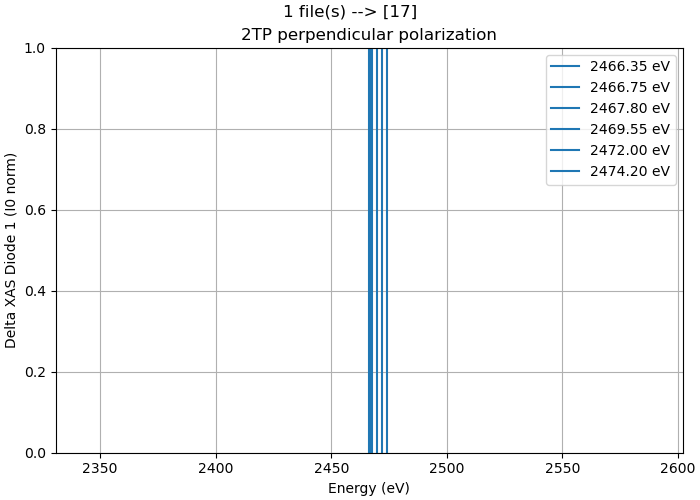

In [9]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

labels = ['200 fs H', '200 fs V', '500 fs H', '500 fs V','2 ps H', '2 ps V']

for i, (run, lbl) in enumerate(zip(runlist[1::2],labels[1::2])):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/norm, err1_low_pump_probe, err1_high_pump_probe, label=lbl)
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('2TP perpendicular polarization')
energies = [2466.35,2466.75,2467.8,2469.55,2472,2474.2] # for MeCN time scans
#energies = [2466.35,2466.75,2468,2470.1,2472,2473.75] # for H2O time scans

for ii, ee in enumerate(energies):
    plt.axvline(ee,label = '{:.2f} eV'.format(ee))
plt.legend()
plt.show()

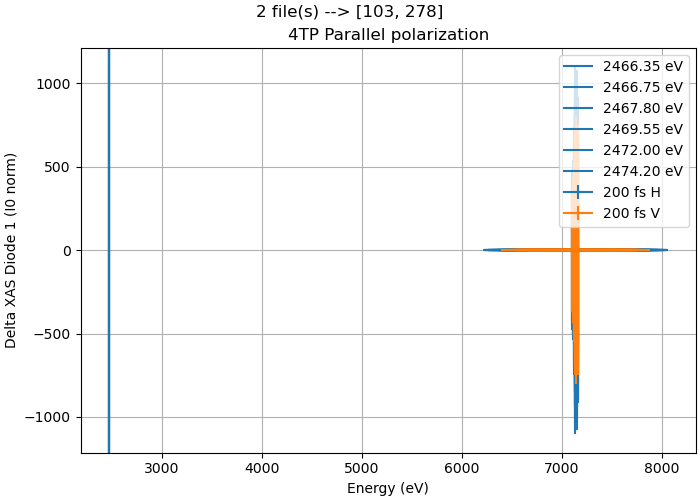

In [90]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

labels = ['200 fs H', '200 fs V', '500 fs H', '500 fs V','2 ps H', '2 ps V']

for i, run in enumerate(runlist[:]):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0]/norm, err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('4TP Parallel polarization')
energies = [2466.35,2466.75,2467.8,2469.55,2472,2474.2] # for MeCN time scans
#energies = [2466.35,2466.75,2468,2470.1,2472,2473.75] # for H2O time scans

for ii, ee in enumerate(energies):
    plt.axvline(ee,label = '{:.2f} eV'.format(ee))
plt.legend()
plt.show()

In [ ]:
fig, (ax1) = plt.subplots(1, figsize=(7, 5), constrained_layout=True)
plt.suptitle('{} file(s) --> {}'.format(len(runlist),str(runlist)))

keys = []

#labels = ['200 fs', '500 fs', '2 ps', '20 ps', '200 ps', '2 ns']
#labels = ['20 ps', '200 ps', '2 ns', '20 ns']
labels = ['scan 18','scan 27',  'scan 167']

for i, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Energy_eV = run_array[key]["Energy_eV"]
        XAS1_pump_probe = run_array[key]["Pump_probe_Diode1"]
        D1p = run_array[key]["DataDiode1_pump"]
        D1u = run_array[key]["DataDiode1_unpump"]
        norm = np.nanmean(D1u[-5:,0])-np.nanmean(D1u[0:5,0])
        
        gs1 = run_array[key]["goodshots1"]
        
        err1_low_pump    = (D1p[:,0]-D1p[:,1])/np.sqrt(gs1)
        err1_high_pump   = (D1p[:,2]-D1p[:,0])/np.sqrt(gs1)
        err1_low_unpump  = (D1u[:,0]-D1u[:,1])/np.sqrt(gs1)
        err1_high_unpump = (D1u[:,2]-D1u[:,0])/np.sqrt(gs1)
        
        err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
        err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)
        
        ax1.axes.errorbar(Energy_eV, (D1u[:,0]-D1u[0,0])/(D1u[-1,0]-D1u[0,0]), err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        #ax1.axes.errorbar(Energy_eV, D1u[:,0], err1_low_pump_probe, err1_high_pump_probe, label=runnumber)
        #ax1.axes.errorbar(Energy_eV, XAS1_pump_probe[:,0], err1_low_pump_probe, err1_high_pump_probe, label=labels[i])
        
        #plt.plot(run_array[key]["Energy_eV"],run_array[key]["Pump_probe_Diode1"][:,0], label=runnumber, marker='.')
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel ("Delta XAS Diode 1 (I0 norm)")
ax1.legend()
ax1.grid()

#ax1.vlines(x=[2469.5, 2470.6, 2472.5, 2473.5, 2474.75, 2480], ymin=-0.3, ymax=0.3, colors='black', ls='--', lw=1)

ax1.set_title('pump probe diode 1')

plt.show()

### convert npy to mat files

In [ ]:
Loaddir = '../Claudio/Reduced_timescans/averaged/'

import scipy.io
f = glob.glob(Loaddir + '/*/*.npy*')

for file in f:
    temp = np.load(file, allow_pickle=True)
    mdic = {"data": temp,}
    fname = file.split('/')[-1].split('.')[0]
    path = os.path.dirname(file) + '/' + fname
    print (path + '/' + fname)
    scipy.io.savemat(path +'.mat', mdic)

In [ ]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_XANES'

runlist = np.arange(24, 26)
#runlist = [25]
##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

DataDiode1_pump = []
DataDiode1_unpump = []
Pump_probe_Diode1 = []
Pump_probe_scan = []
goodshots1 = []
datafiles = []

#print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))
    datafiles.extend(file)
    run_array = np.load(file[0], allow_pickle=True).item()
    for key in run_array.keys():
        DataDiode1_pump.append(run_array[key]["DataDiode1_pump"])
        DataDiode1_unpump.append(run_array[key]["DataDiode1_unpump"])
        Pump_probe_Diode1.append(run_array[key]["Pump_probe_Diode1"])
        goodshots1.append(run_array[key]["goodshots1"])
        Energy_eV = run_array[key]["Energy_eV"]
        print (run, len(run_array[key]["DataDiode1_pump"]))
datafiles = sorted(datafiles, key = os.path.getmtime)
titlestring_stack = pgroup + ' --- ' +str(runlist)
DataDiode1_pump = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1 = np.asarray(goodshots1)

print ('{} scans, {} steps'.format(len(datafiles), np.shape(Pump_probe_Diode1)[1]))
    

In [ ]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_XANES'

runlist = np.arange(24, 26)
#runlist = [25]
##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

DataDiode1_pump = []
DataDiode1_unpump = []
Pump_probe_Diode1 = []
DataDiode2_pump = []
DataDiode2_unpump = []
Pump_probe_Diode2 = []
goodshots1 = []
goodshots2 = []
datafiles = []

#print (runlist)
for run in runlist:
    file = glob.glob(Loaddir + '/*{:04d}*/*run_array*'.format(run))
    datafiles.extend(file)
    run_array = np.load(file[0], allow_pickle=True).item()
    for key in run_array.keys():
        DataDiode1_pump.append(run_array[key]["DataDiode1_pump"])
        DataDiode1_unpump.append(run_array[key]["DataDiode1_unpump"])
        Pump_probe_Diode1.append(run_array[key]["Pump_probe_Diode1"])
        goodshots1.append(run_array[key]["goodshots1"])
        DataDiode2_pump.append(run_array[key]["DataDiode2_pump"])
        DataDiode2_unpump.append(run_array[key]["DataDiode2_unpump"])
        Pump_probe_Diode2.append(run_array[key]["Pump_probe_Diode2"])
        goodshots2.append(run_array[key]["goodshots2"])
        Energy_eV = run_array[key]["Energy_eV"]
        print (run, np.shape(run_array[key]["DataDiode1_pump"]), np.shape(run_array[key]["DataDiode2_pump"]))
datafiles = sorted(datafiles, key = os.path.getmtime)
titlestring_stack = pgroup + ' --- ' +str(runlist)
DataDiode1_pump = np.asarray(DataDiode1_pump)
DataDiode1_unpump = np.asarray(DataDiode1_unpump)
Pump_probe_Diode1 = np.asarray(Pump_probe_Diode1)
goodshots1 = np.asarray(goodshots1)
DataDiode2_pump = np.asarray(DataDiode2_pump)
DataDiode2_unpump = np.asarray(DataDiode2_unpump)
Pump_probe_Diode2 = np.asarray(Pump_probe_Diode2)
goodshots2 = np.asarray(goodshots2)

print ('{} scans, {} steps'.format(len(datafiles), np.shape(Pump_probe_Diode1)[1]))
    